# Inference Kernel Demo

This is the kernel I’ve used for my recent submissions. It takes about 5-6 hours on the test set, using only CPU. 

I’ve provided this kernel because a lot of people have problems making submissions. This method works and has never errored out for me. (Although I haven't tried making a submission using the GPU yet -- so no guarantees there.)

It uses BlazeFace for face extraction (see also [my BlazeFace kernel](https://www.kaggle.com/humananalog/starter-blazeface-pytorch)) and ResNeXt50 as the classifier model.

We take the average prediction over 17 frames from each video. (Why 17? Using more frames makes the kernel slower, but doesn't appear to improve the score much. I used an odd number so we don't always land on even frames.)

**Please use this kernel only to learn from...** Included is the checkpoint for a ResNeXt50 model that hasn't really been trained very well yet. I'm sure you can improve on it by training your own model!

You could use the included trained weights to get yourself an easy top-50 score on the leaderboard (as of 24 Jan 2020) but it’s nicer to use it as a starting point for your own work. :-)

In [1]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

## Get the test videos

In [2]:
test_dir = "/kaggle/input/deepfake-sample-set"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
len(test_videos)

22

## Create helpers

In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.3.0
CUDA version: 10.0.130
cuDNN version: 7603


In [4]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [5]:
import sys
sys.path.insert(0, "/kaggle/input/blazeface-pytorch")
sys.path.insert(0, "/kaggle/input/deepfakes-inference-demo")

# ---- Blazeface ----

In [6]:
# from blazeface import BlazeFace
# facedet = BlazeFace().to(gpu)
# facedet.load_weights("/kaggle/input/blazeface-pytorch/blazeface.pth")
# facedet.load_anchors("/kaggle/input/blazeface-pytorch/anchors.npy")
# _ = facedet.train(False)

In [7]:
# from helpers.read_video_1 import VideoReader
# from helpers.face_extract_1 import FaceExtractor


# video_reader = VideoReader()
# video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
# face_extractor = FaceExtractor(video_read_fn, facedet)

# ---------------

In [8]:
input_size = 224
frames_per_video = 50

In [9]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

In [10]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [11]:
import torch.nn as nn
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        self.fc = nn.Linear(2048, 1)

In [12]:
checkpoint = torch.load("/kaggle/input/deepfakes-inference-demo/resnext.pth", map_location=gpu)

Resmodel = MyResNeXt().to(gpu)
Resmodel.load_state_dict(checkpoint)
_ = Resmodel.eval()

del checkpoint

# **Frame Seperation**

In [13]:
from PIL import Image
import skimage
from skimage import data
from skimage.color import rgb2gray
from skimage.color import gray2rgb
from skimage import measure
from skimage.metrics import structural_similarity as ssim
import argparse
import random
import time

In [14]:
def structuralSimilarityIndex(imageA, imageB):
#     dim = (50, 50)
#     A = cv2.resize(imageA, dim, interpolation = cv2.INTER_AREA)
#     B = cv2.resize(imageB, dim, interpolation = cv2.INTER_AREA)

#     For SSIM Index -> always conver image to a gray-scale image
    ans = ssim(imageA, imageB, full = True)
    ret = ans[0] #Returns value between -1 and 1
    ret += 1 #I scaled up the returned value 
    ret /= 2 #By dividing it: i limited the returned value between 0 and 1.
    return ret # So, now value close to 0 means mismatch, value close to 1 means match.

#print(structuralSimilarityIndex(image3, image3))
#print(structuralSimilarityIndex(image3, image4))

In [15]:
def read_frames(path):
    
    capture = cv2.VideoCapture(path)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frames = []
    i = 0
    for frame_idx in range(int(frame_count)):
        # Get the next frame, but don't decode if we're not using it.
        ret = capture.grab()
        if not ret: 
            print("Error grabbing frame %d from movie %s" % (frame_idx, path))
            
        if i % 2 == 0:
            ret, frame = capture.retrieve()
            if ret == False:
                break
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        i += 1
    
    capture.release()
    
    print("Total frames:   " + str(len(frames)))

    return frames

# ----- Faster Tensor Reader -----

In [16]:
# !cp /kaggle/input/decord/install.sh . && chmod  +x install.sh && ./install.sh 

In [17]:
# sys.path.insert(0,'/kaggle/working/reader/python')

# from decord import VideoReader
# from decord import cpu, gpu
# from decord.bridge import set_bridge

# set_bridge('torch')

In [18]:
# def read_frames_faster(path):
#     video = VideoReader(path, ctx=gpu())
#     data = video.get_batch(range(len(video)))
    
# #     numpy_data = [data.detach().cpu().numpy() for data in tensor_data]
#     return data

In [19]:
# import torchvision.transforms as transforms

# pil2tensor = transforms.ToTensor()
# tensor2pil = transforms.ToPILImage()

# def plot_image(tensor):
#     plt.figure()
#     # imshow needs a numpy array with the channel dimension
#     # as the the last dimension so we have to transpose things.
#     plt.imshow(tensor.cpu().numpy().transpose(1, 2, 0))
#     plt.show()

# -----------------------

In [20]:
def process_frames(video_path):
    frames = read_frames(video_path)
    
    # Extra
    ret = []
    tot = 0
    for i in range(0, len(frames)):
        tot += 1
        if tot % 6 == 0:
            ret.append(frames[i])
        if len(ret) == 50:
            break
    
    if len(ret) == 50:
        return ret
    else:
        while len(ret) < 50:
            rand = random.randrange(0, len(frames))
            #print("Random: " + str(rand))
            ret.append(frames[rand])
        return ret
    
    # Extra 
    
    
    gray_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in frames]
    print(len(frames))

    g = [[] for i in range(len(gray_frames))]
    mask= []
    resized_frames = []

    lmt = len(gray_frames)
    pair = gray_frames[0].shape

    for i in range(lmt + 1):
        mask.append(0)

        if i == lmt:
            continue
        if pair[0] == 1080 and pair[1] == 1920:
            resized_frames.append(cv2.resize(gray_frames[i], (180, 320), interpolation = cv2.INTER_AREA))
        else:
            resized_frames.append(cv2.resize(gray_frames[i], (320, 180), interpolation = cv2.INTER_AREA))

    def union(start_idx, calls):
        mask[start_idx] = 1
        curr_img = resized_frames[start_idx]  #Current index is marked as 1
        g[calls].append(start_idx)
        for i in range(start_idx + 1, lmt):
            if mask[i] == 1:
                continue
            next_img = (resized_frames[i])
            if(structuralSimilarityIndex(next_img, curr_img) >= 0.97):
                mask[i] = 1
                g[calls].append(i)  #Similar frames are put together
            else:
                break

    index = 0 
    total_sets = 0
    for i in range(lmt):
        if mask[i] == 0:
            union(i, index)
            total_sets += 1
            index += 1
    
   # print("Total disjoint sets:  " + str(total_sets))
    
    final_frames =  []
    index_taken = [] #
    visit = [0 for i in range(len(frames))]
    for i in range(total_sets):
#             print("Rand: " + str(g[i][0]))
#         if i >= frames_per_video:
#            break
        final_frames.append(frames[g[i][0]])
        visit[g[i][0]] = 1
#         index_taken.append(g[i][0])

    while True:
        if len(final_frames) >= frames_per_video:
            break
        rand = random.randrange(0, len(frames))
        if visit[rand] == 1:
            continue
        else:
            visit[rand] = 1
            #print("Random number -> " + str(rand))
            final_frames.append(frames[rand])
            
    return final_frames        

# YOLOv2 Face Detector

In [21]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [22]:
def load_mobilenetv2_224_075_detector(path):
    input_tensor = Input(shape=(224, 224, 3))
    output_tensor = MobileNetV2(weights=None, include_top=False, input_tensor=input_tensor, alpha=0.75).output
    output_tensor = ZeroPadding2D()(output_tensor)
    output_tensor = Conv2D(kernel_size=(3, 3), filters=5)(output_tensor)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.load_weights(path)
    
    return model

In [23]:
mobilenetv2 = load_mobilenetv2_224_075_detector("/kaggle/input/facedetection-mobilenetv2/facedetection-mobilenetv2-size224-alpha0.75.h5")

In [24]:
# Converts A:B aspect rate to B:A
def transpose_shots(shots):
    return [(shot[1], shot[0], shot[3], shot[2], shot[4]) for shot in shots]

#That constant describe pieces for 16:9 images
SHOTS = {
    # fast less accurate
    '2-16/9' : {
        'aspect_ratio' : 16/9,
        'shots' : [
             (0, 0, 9/16, 1, 1),
             (7/16, 0, 9/16, 1, 1)
        ]
    },
    # slower more accurate
    '10-16/9' : {
        'aspect_ratio' : 16/9,
        'shots' : [
             (0, 0, 9/16, 1, 1),
             (7/16, 0, 9/16, 1, 1),
             (0, 0, 5/16, 5/9, 0.5),
             (0, 4/9, 5/16, 5/9, 0.5),
             (11/48, 0, 5/16, 5/9, 0.5),
             (11/48, 4/9, 5/16, 5/9, 0.5),
             (22/48, 0, 5/16, 5/9, 0.5),
             (22/48, 4/9, 5/16, 5/9, 0.5),
             (11/16, 0, 5/16, 5/9, 0.5),
             (11/16, 4/9, 5/16, 5/9, 0.5),
        ]
    }
}

# 9:16 respectively
SHOTS_T = {
    '2-9/16' : {
        'aspect_ratio' : 9/16,
        'shots' : transpose_shots(SHOTS['2-16/9']['shots'])
    },
    '10-9/16' : {
        'aspect_ratio' : 9/16,
        'shots' : transpose_shots(SHOTS['10-16/9']['shots'])
    }
}

def r(x):
    return int(round(x))

def sigmoid(x):
    return 1 / (np.exp(-x) + 1)

def non_max_suppression(boxes, p, iou_threshold):
    if len(boxes) == 0:
        return np.array([])

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    indexes = np.argsort(p)
    true_boxes_indexes = []

    while len(indexes) > 0:
        true_boxes_indexes.append(indexes[-1])

        intersection = np.maximum(np.minimum(x2[indexes[:-1]], x2[indexes[-1]]) - np.maximum(x1[indexes[:-1]], x1[indexes[-1]]), 0) * np.maximum(np.minimum(y2[indexes[:-1]], y2[indexes[-1]]) - np.maximum(y1[indexes[:-1]], y1[indexes[-1]]), 0)
        iou = intersection / ((x2[indexes[:-1]] - x1[indexes[:-1]]) * (y2[indexes[:-1]] - y1[indexes[:-1]]) + (x2[indexes[-1]] - x1[indexes[-1]]) * (y2[indexes[-1]] - y1[indexes[-1]]) - intersection)

        indexes = np.delete(indexes, -1)
        indexes = np.delete(indexes, np.where(iou >= iou_threshold)[0])

    return boxes[true_boxes_indexes]

def union_suppression(boxes, threshold):
    if len(boxes) == 0:
        return np.array([])

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    indexes = np.argsort((x2 - x1) * (y2 - y1))
    result_boxes = []

    while len(indexes) > 0:
        intersection = np.maximum(np.minimum(x2[indexes[:-1]], x2[indexes[-1]]) - np.maximum(x1[indexes[:-1]], x1[indexes[-1]]), 0) * np.maximum(np.minimum(y2[indexes[:-1]], y2[indexes[-1]]) - np.maximum(y1[indexes[:-1]], y1[indexes[-1]]), 0)
        min_s = np.minimum((x2[indexes[:-1]] - x1[indexes[:-1]]) * (y2[indexes[:-1]] - y1[indexes[:-1]]), (x2[indexes[-1]] - x1[indexes[-1]]) * (y2[indexes[-1]] - y1[indexes[-1]]))
        ioms = intersection / (min_s + 1e-9)
        neighbours = np.where(ioms >= threshold)[0]
        if len(neighbours) > 0:
            result_boxes.append([min(np.min(x1[indexes[neighbours]]), x1[indexes[-1]]), min(np.min(y1[indexes[neighbours]]), y1[indexes[-1]]), max(np.max(x2[indexes[neighbours]]), x2[indexes[-1]]), max(np.max(y2[indexes[neighbours]]), y2[indexes[-1]])])
        else:
            result_boxes.append([x1[indexes[-1]], y1[indexes[-1]], x2[indexes[-1]], y2[indexes[-1]]])

        indexes = np.delete(indexes, -1)
        indexes = np.delete(indexes, neighbours)

    return result_boxes

class FaceDetector():
    """
    That's API you can easily use to detect faces
    
    __init__ parameters:
    -------------------------------
    model - model to infer
    shots - list of aspect ratios that images could be (described earlier)
    image_size - model's input size (hardcoded for mobilenetv2)
    grids - model's output size (hardcoded for mobilenetv2)
    union_threshold - threshold for union of predicted boxes within multiple shots
    iou_threshold - IOU threshold for non maximum suppression used to merge YOLO detected boxes for one shot,
                    you do need to change this because there are one face per image as I can see from the samples
    prob_threshold - probability threshold for YOLO algorithm, you can balance beetween precision and recall using this threshold
    
    detect parameters:
    -------------------------------
    frame - (1920, 1080, 3) or (1080, 1920, 3) RGB Image
    returns: list of 4 element tuples (left corner x, left corner y, right corner x, right corner y) of detected boxes within [0, 1] range (see box draw code below)
    """
    def __init__(self, model=mobilenetv2, shots=[SHOTS['10-16/9'], SHOTS_T['10-9/16']], image_size=224, grids=7, iou_threshold=0.1, union_threshold=0.1):
        self.model = model
        self.shots = shots
        self.image_size = image_size
        self.grids = grids
        self.iou_threshold = iou_threshold
        self.union_threshold = union_threshold
        self.prob_threshold = 0.7
        
    
    def detect(self, frame, threshold = 0.7):
        original_frame_shape = frame.shape
        self.prob_threshold = threshold
        aspect_ratio = None
        for shot in self.shots:
            if abs(frame.shape[1] / frame.shape[0] - shot["aspect_ratio"]) < 1e-9:
                aspect_ratio = shot["aspect_ratio"]
                shots = shot
        
        assert aspect_ratio is not None
        
        c = min(frame.shape[0], frame.shape[1] / aspect_ratio)
        slice_h_shift = r((frame.shape[0] - c) / 2)
        slice_w_shift = r((frame.shape[1] - c * aspect_ratio) / 2)
        if slice_w_shift != 0 and slice_h_shift == 0:
            frame = frame[:, slice_w_shift:-slice_w_shift]
        elif slice_w_shift == 0 and slice_h_shift != 0:
            frame = frame[slice_h_shift:-slice_h_shift, :]

        frames = []
        for s in shots["shots"]:
            frames.append(cv2.resize(frame[r(s[1] * frame.shape[0]):r((s[1] + s[3]) * frame.shape[0]), r(s[0] * frame.shape[1]):r((s[0] + s[2]) * frame.shape[1])], (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST))
        frames = np.array(frames)

        predictions = self.model.predict(frames, batch_size=len(frames), verbose=0)

        boxes = []
        prob = []
        shots = shots['shots']
        for i in range(len(shots)):
            slice_boxes = []
            slice_prob = []
            for j in range(predictions.shape[1]):
                for k in range(predictions.shape[2]):
                    p = sigmoid(predictions[i][j][k][4])
                    if not(p is None) and p > self.prob_threshold:
                        px = sigmoid(predictions[i][j][k][0])
                        py = sigmoid(predictions[i][j][k][1])
                        pw = min(math.exp(predictions[i][j][k][2] / self.grids), self.grids)
                        ph = min(math.exp(predictions[i][j][k][3] / self.grids), self.grids)
                        if not(px is None) and not(py is None) and not(pw is None) and not(ph is None) and pw > 1e-9 and ph > 1e-9:
                            cx = (px + j) / self.grids
                            cy = (py + k) / self.grids
                            wx = pw / self.grids
                            wy = ph / self.grids
                            if wx <= shots[i][4] and wy <= shots[i][4]:
                                lx = min(max(cx - wx / 2, 0), 1)
                                ly = min(max(cy - wy / 2, 0), 1)
                                rx = min(max(cx + wx / 2, 0), 1)
                                ry = min(max(cy + wy / 2, 0), 1)

                                lx *= shots[i][2]
                                ly *= shots[i][3]
                                rx *= shots[i][2]
                                ry *= shots[i][3]

                                lx += shots[i][0]
                                ly += shots[i][1]
                                rx += shots[i][0]
                                ry += shots[i][1]

                                slice_boxes.append([lx, ly, rx, ry])
                                slice_prob.append(p)

            slice_boxes = np.array(slice_boxes)
            slice_prob = np.array(slice_prob)

            slice_boxes = non_max_suppression(slice_boxes, slice_prob, self.iou_threshold)

            for sb in slice_boxes:
                boxes.append(sb)


        boxes = np.array(boxes)
        boxes = union_suppression(boxes, self.union_threshold)

        for i in range(len(boxes)):
            boxes[i][0] /= original_frame_shape[1] / frame.shape[1]
            boxes[i][1] /= original_frame_shape[0] / frame.shape[0]
            boxes[i][2] /= original_frame_shape[1] / frame.shape[1]
            boxes[i][3] /= original_frame_shape[0] / frame.shape[0]

            boxes[i][0] += slice_w_shift / original_frame_shape[1]
            boxes[i][1] += slice_h_shift / original_frame_shape[0]
            boxes[i][2] += slice_w_shift / original_frame_shape[1]
            boxes[i][3] += slice_h_shift / original_frame_shape[0]

        return list(boxes)

In [25]:
def get_boxes_points(boxes, frame_shape):
    result = []
    for box in boxes:
        lx = int(round(box[0] * frame_shape[1]))
        ly = int(round(box[1] * frame_shape[0]))
        rx = int(round(box[2] * frame_shape[1]))
        ry = int(round(box[3] * frame_shape[0]))
        result.append((lx, ly, rx, ry))
    return result

In [26]:
yolo_model = FaceDetector()

In [27]:
def predict_on_video(video_path, batch_size):
    try:
        
#         start_time = time.time()
        frames = process_frames(video_path)
#         print("Frame process : ", time.time() - start_time)
        
        print(len(frames))
        
        faces = []
        
#         time2 = time.time()
        for frame in frames:
            yolo_boxes = yolo_model.detect(frame, 0.7)
            yb = get_boxes_points(yolo_boxes, frame.shape)
            
            for b in yb:
                lx, ly, rx, ry = b
                # x, y, w, h here
                # ax.add_patch(Rectangle((lx,ly),rx - lx,ry - ly,linewidth=2,edgecolor='red',facecolor='none'))
                img_crop = frame[ly:ry, lx:rx]
                faces.append(img_crop)
#         print("Face process : ", time.time() - time2)
        sample_faces = random.sample(faces, len(faces))
        if len(sample_faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            x = np.zeros((batch_size, input_size, input_size, 3), dtype=np.uint8)

            # If we found any faces, prepare them for the model.
            n = 0
            
            for face in sample_faces:
                resized_face = isotropically_resize_image(face, input_size)
                resized_face = make_square_image(resized_face)

                if n < batch_size:
                    x[n] = resized_face
                    n += 1
                else:
                    print("WARNING: have %d faces but batch size is %d" % (n, batch_size))
                    
            if n > 0:
                x = torch.tensor(x, device=gpu).float()

                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)

                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred = Resmodel(x)
                    y_pred = torch.sigmoid(y_pred.squeeze())
                    return y_pred[:n].mean().item()
                
#         print("Total : ", time.time() - start_time)
        
    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))

    return 0.5

In [28]:
# print(test_videos[0])

# # frames = read_frames_faster(os.path.join(test_dir, test_videos[0]))
# start_time = time.time()
# out = predict_on_video(os.path.join(test_dir, test_videos[1]), batch_size=frames_per_video)
# print("Total : ", time.time() - start_time)
# print(out)

In [29]:
from concurrent.futures import ThreadPoolExecutor

def predict_on_video_set(videos, num_workers):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(test_dir, filename), batch_size=frames_per_video)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

## Speed test

The leaderboard submission must finish within 9 hours. With 4000 test videos, that is `9*60*60/4000 = 8.1` seconds per video. So if the average time per video is greater than ~8 seconds, the kernel will be too slow!

In [30]:
speed_test = True  # you have to enable this manually

In [31]:
if speed_test:
    torch.cuda.empty_cache()
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = []
    for video in speedtest_videos:
        out = predict_on_video(os.path.join(test_dir, video), batch_size=frames_per_video)
        predictions.append(out)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

Total frames:   150
50
Total frames:   150
50
Total frames:   150
50
Total frames:   149
50
Total frames:   150
50


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in exp


Elapsed 25.831847 sec. Average per video: 5.166369 sec.


In [32]:
predictions

[0.8917793035507202,
 0.4242251515388489,
 0.5974590182304382,
 0.9619265794754028,
 0.7801046371459961]

## Make the submission

In [33]:
predictions = []
torch.cuda.empty_cache()
for video in test_videos:
    out = predict_on_video(os.path.join(test_dir, video), batch_size=frames_per_video)
    print("Value of out: " + str(out))
#     if out >= 0.85:
#         out = 0.99999999
#     elif out <= 0.3:
#         out = 0.01
    predictions.append(out)
    print(out)

Total frames:   150
50
Value of out: 0.8809096813201904
0.8809096813201904
Total frames:   150
50
Value of out: 0.4680227041244507
0.4680227041244507
Total frames:   150
50
Value of out: 0.587143063545227
0.587143063545227
Total frames:   149
50
Value of out: 0.9744592308998108
0.9744592308998108
Total frames:   150
50


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in exp


Value of out: 0.7753207087516785
0.7753207087516785
Total frames:   150
50
Value of out: 0.2197372317314148
0.2197372317314148
Total frames:   150
50
Value of out: 0.7384054660797119
0.7384054660797119
Total frames:   150
50
Value of out: 0.5495702624320984
0.5495702624320984
Total frames:   150
50
Value of out: 0.8982484340667725
0.8982484340667725
Total frames:   150
50
Value of out: 0.02924565225839615
0.02924565225839615
Total frames:   149
50
Value of out: 0.21080061793327332
0.21080061793327332
Total frames:   150
50
Value of out: 0.0028972518630325794
0.0028972518630325794
Total frames:   150
50
Value of out: 0.9911201000213623
0.9911201000213623
Total frames:   150
50
Value of out: 0.5702213048934937
0.5702213048934937
Total frames:   150
50
Value of out: 0.01403127983212471
0.01403127983212471
Total frames:   150
50
Value of out: 0.38661062717437744
0.38661062717437744
Total frames:   150
50
Value of out: 0.9951736330986023
0.9951736330986023
Total frames:   150
50
Value of ou

In [34]:
submission_df = pd.DataFrame({"filename": test_videos, "label": predictions})
print(submission_df)
submission_df.to_csv("submission.csv", index=False)

               filename     label
0   aagfhgtpmv_FAKE.mp4  0.880910
1   aapnvogymq_FAKE.mp4  0.468023
2   abofeumbvv_FAKE.mp4  0.587143
3   acxwigylke_FAKE.mp4  0.974459
4   akxoopqjqz_FAKE.mp4  0.775321
5   anpuvshzoo_REAL.mp4  0.219737
6   apogckdfrz_FAKE.mp4  0.738405
7   asaxgevnnp_REAL.mp4  0.549570
8   asdpeebotb_FAKE.mp4  0.898248
9   atkdltyyen_REAL.mp4  0.029246
10  beboztfcme_REAL.mp4  0.210801
11  bilnggbxgu_REAL.mp4  0.002897
12  blpchvmhxx_FAKE.mp4  0.991120
13  cffffbcywc_FAKE.mp4  0.570221
14  dbnygxtwek_REAL.mp4  0.014031
15  dhcndnuwta_REAL.mp4  0.386611
16  diomeixhrg_FAKE.mp4  0.995174
17  drcyabprvt_REAL.mp4  0.008299
18  dsjbknkujw_REAL.mp4  0.284073
19  ecuvtoltue_FAKE.mp4  0.977264
20  ehtdtkmmli_REAL.mp4  0.142114
21  eqnoqyfquo_REAL.mp4  0.008869


In [35]:
submission_df.head()

,filename,label
0,aagfhgtpmv_FAKE.mp4,0.880910
1,aapnvogymq_FAKE.mp4,0.468023
2,abofeumbvv_FAKE.mp4,0.587143
3,acxwigylke_FAKE.mp4,0.974459
4,akxoopqjqz_FAKE.mp4,0.775321


In [38]:
import pandas as pd
csvData = pd.read_csv("../input/deepfake-sample-set/csvData.csv")
csvData

,Name,Label
0,aagfhgtpmv.mp4,1
1,aapnvogymq.mp4,1
2,abofeumbvv.mp4,1
3,acxwigylke.mp4,1
4,akxoopqjqz.mp4,1
5,anpuvshzoo.mp4,0
6,apogckdfrz.mp4,1
7,asaxgevnnp.mp4,0
8,asdpeebotb.mp4,1
9,atkdltyyen.mp4,0


In [53]:
print(len(submission_df))
ara = csvData.Label
#ara
submission_df.shape
#for columns in submission_df.columns:
#    print(columns)
pred = submission_df.label
#print(pred)
tempData = pd.DataFrame({'Name': csvData.Name ,'actual': ara, 'predicted' : pred})
tempData.shape
print(tempData)
loss = logLoss(tempData)
print("Loss: ")
print(loss)

22
              Name  actual  predicted
0   aagfhgtpmv.mp4       1   0.880910
1   aapnvogymq.mp4       1   0.468023
2   abofeumbvv.mp4       1   0.587143
3   acxwigylke.mp4       1   0.974459
4   akxoopqjqz.mp4       1   0.775321
5   anpuvshzoo.mp4       0   0.219737
6   apogckdfrz.mp4       1   0.738405
7   asaxgevnnp.mp4       0   0.549570
8   asdpeebotb.mp4       1   0.898248
9   atkdltyyen.mp4       0   0.029246
10  beboztfcme.mp4       0   0.210801
11  bilnggbxgu.mp4       0   0.002897
12  blpchvmhxx.mp4       1   0.991120
13  cffffbcywc.mp4       1   0.570221
14  dbnygxtwek.mp4       0   0.014031
15  dhcndnuwta.mp4       0   0.386611
16  diomeixhrg.mp4       1   0.995174
17  drcyabprvt.mp4       0   0.008299
18  dsjbknkujw.mp4       0   0.284073
19  ecuvtoltue.mp4       1   0.977264
20  ehtdtkmmli.mp4       0   0.142114
21  eqnoqyfquo.mp4       0   0.008869
Loss: 
0.228660034569695


In [51]:
def logLoss(data):
    loss = 0.0
    actual = data['actual']
    predicted =  data['predicted']
    total = len(actual)
    for i in range(total):
        loss += ((1.0  * actual[i]) * np.log(predicted[i]) + (1.0 * (1 - actual[i])) * np.log(1 - predicted[i]))
    #print(loss)
    loss = (-1.0 * loss) / (1.0 * total)
    #print("Loss: ")
    #print(loss)
    return loss

AttributeError: 'DataFrame' object has no attribute 'name'

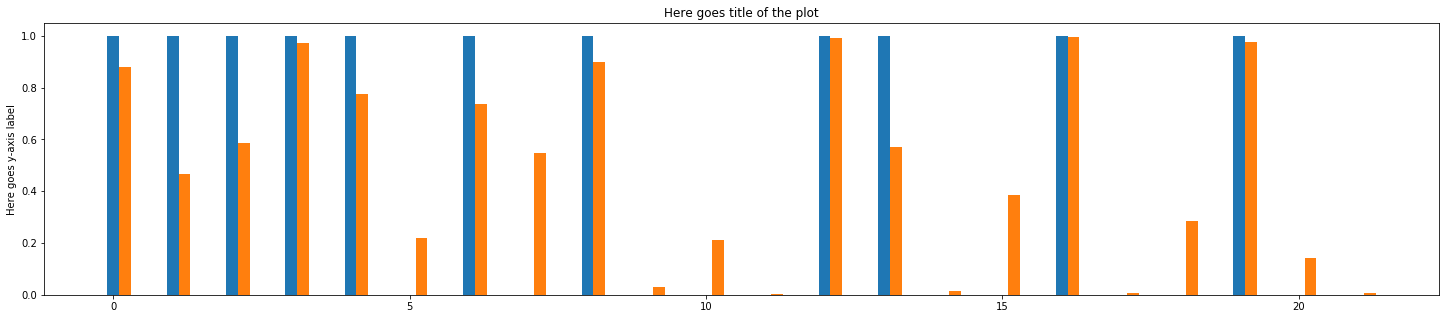

In [77]:
ind = np.arange(len(ara))
bluebar = ara
orangebar = pred
#print(bluebar)
#print(orangebar)
plt.figure(figsize = (25, 5))
width = 0.2
plt.bar(ind, bluebar , width, label='Ground truth')
plt.bar(ind + width, orangebar, width, label='Prediction')
names = csvData.Name
plt.ylabel('Here goes y-axis label')
plt.title('Here goes title of the plot')
plt.xticks(ind + width / 2,(submission_df.filename), rotation = 'vertical')

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()